# Ejercicio Default

#### Hecho por Juan Esteban Garzón y Nicolás Florián Ortiz

In [87]:
# Preámbulo

import pandas as pd
import yfinance as yf
import numpy as np
import openpyxl
import warnings
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris 
from sklearn.linear_model import RidgeCV
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from scipy.stats import randint, expon




#Para quitar los warnings
warnings.filterwarnings("ignore")


Para iniciar el desarrollo del ejercicio, se filtra la base de datos seleccionada para desarrollar el ejercicio propuesto

In [7]:
# Importo los datos
datos = pd.read_excel('loans.xlsx')

Con el objetivo de volver algunas trasnformar las variables cualitativas a cuantitativas, se propone transformar aquellas variables que:
 1. Cuentan con dos variables: Se transforman a dummies
 2. Cuentan con más de dos variables: Se usa la metodología “One-Hot Encodig” donde a cada tipo de respuesta en una variable se le asigna una columna  la cual a través de dummies revisa si corresponde a cada persona (No se realiza para la variable "Grade" dado qué se considera un efecto constante entre el cambio de niveles de riesgo)

In [9]:
# Manejo de variables

#Para el loan status
dummies_loan = {'Current': 0, 'Fail': 1}
datos['loan_status'] = datos['loan_status'].map(dummies_loan)

#Para la calificación de riesgo
num_grade = {'A': 1, 'B': 2, 'C': 3,'D':4,'E':5,'F':6,'G':7}
datos['grade'] = datos['grade'].map(num_grade)

#Para la variable "home_ownership"
home_ownership_dummies = pd.get_dummies(datos['home_ownership'], prefix='home_ownership')
home_ownership_dummies = home_ownership_dummies.astype(int)
datos = pd.concat([datos, home_ownership_dummies], axis=1)
datos = datos.drop(columns=['home_ownership'])

#Para la variable "verification"
verification_dummies = pd.get_dummies(datos['verification_status'], prefix='verification_status')
verification_dummies = verification_dummies.astype(int)
datos = pd.concat([datos, verification_dummies], axis=1)
datos = datos.drop(columns=['verification_status'])

#Para la issue date
issue_d_dummies = pd.get_dummies(datos['issue_d'], prefix='issue_d')
issue_d_dummies = issue_d_dummies.astype(int)
datos = pd.concat([datos, issue_d_dummies], axis=1)
datos = datos.drop(columns=['issue_d'])

#Para la variable de proposito
purpose_dummies = pd.get_dummies(datos['purpose'], prefix='purpose')
purpose_dummies = purpose_dummies.astype(int)
datos = pd.concat([datos, purpose_dummies], axis=1)
datos = datos.drop(columns=['purpose'])

#Para la variable "initial_list_status"
dummies_initial = {'w': 0, 'f':1}
datos['initial_list_status'] = datos['initial_list_status'].map(dummies_initial)

#Para la variable "Aplication type"
dummies_application = {'Individual': 0, 'Joint App':1}
datos['application_type'] = datos['application_type'].map(dummies_application)

Para el establecimiento de las variables dependientes e independientes del modelo, se desarrolla una "separación" de la base de datos donde:
 - Y: Variable dependiente que cuenta con las personas defaulters y non-defaulters
 - X: Variables independiente que cuenta con la caracteristicas de las personas

Es importante recalcar qué con el objetivo de comparar y ser más correctos metodológicamente se realizó un oversampling ya que la muestra se encontraba mayormente concentrada en las personas non-defaulters que son más del 85% de los encuestados. Con base a esto, se decide remuestrear dejando la base con una proporción de 70% non - defaulters y 30% defaulters

In [10]:
# Separar características (X) y etiquetas (y)
X = datos.iloc[:, 1:]
y = datos.iloc[:, 0]

In [11]:
oversampler = RandomOverSampler(sampling_strategy=0.3, random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Eliminar filas con valores NaN en y_resampled
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)
resampled_data = resampled_data.dropna(subset=[y_resampled.name])

X_resampled = resampled_data.iloc[:, :-1]
y_resampled = resampled_data.iloc[:, -1]

# Undersampling a los 0 (Current) para alcanzar un 70%
undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)


## 1. Evaluación de modelos QDA,Árboles y 5-NN 

El desarrollo de los modelos se dividirá en 2: Inicialmente se realizará el proceso de la muestra sin rebalancear y posteriormente de la muestra rebalanceda. Esto para identificar y comparar las diferencias entre ambos

### 1.1 Modelo QDA

#### Modelo QDA con muestra sin rebalancear (Natural)

In [13]:
# MODELO QDA (Natural)
qda = QuadraticDiscriminantAnalysis()

# 10 fold CV: Se usa la función de cross validation que utilizará cómo "train" 10 folds para compararlo con 1 folds. Esto se hará para 10 folds de testeo distintos
scores_qda = cross_val_score(qda, X, y, cv=10)
scores_promedios_qda = np.mean(scores_qda)


# 10 fold CV para "precision"
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(qda, X, y, cv=10, scoring=precision_scorer)


# Resultado de precisión
print(f"El resultado de precisión a través de 10 fold CV fue: {scores_promedios_qda}")
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision.mean()}")

El resultado de precisión a través de 10 fold CV fue: 0.7883404255319149
El resultado de precisión a través de Presicion por 10 fold CV fue: 0.2750089842223686


#### Modelo QDA con muestra rebalanceada (Natural)

In [14]:
# MODELO QDA (Oversampling)

qda = QuadraticDiscriminantAnalysis()

# 10 fold CV: Se usa la función de cross validation que utilizará cómo "train" 10 folds para compararlo con 1 folds. Esto se hará para 10 folds de testeo distintos
scores_qda = cross_val_score(qda, X_resampled, y_resampled, cv=10)
scores_promedios_qda = np.mean(scores_qda)


# 10 fold CV para "precision"
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(qda, X_resampled, y_resampled, cv=10, scoring=precision_scorer)


# Resultado de precisión
print(f"El resultado de precisión a través de 10 fold CV para la muestra modificada fue: {scores_promedios_qda}")
print(f"El resultado de precisión a través de Presicion por 10 fold CV para la muestra modificada fue: {puntuaciones_precision.mean()}")

El resultado de precisión a través de 10 fold CV para la muestra modificada fue: 0.6385815658963807
El resultado de precisión a través de Presicion por 10 fold CV para la muestra modificada fue: 0.6370017971434292


### 1.2 Árboles de clasificación

Para el desarrollo de la metodología de Árboles de clasificación se proponen 2 HP que se encuentran en la linea [4], en este se límita la cantidad de ramas que el módelo puede desarrollar, es este caso 4 y también se limita el mínimo de personas por nodo; Estos parametros se establecen para evitar overfitting, qué, en primera instancia hace que el modelo no sea tan específico dandole más precisión y además, mejora la predicción fuera de muestra

#### Árboles de clasificación con la muestra sin rebalancear

La precisión del árbol de clasificación a través de 10 fold CV fue de: 84.91%
El resultado de precisión a través de Presicion por 10 fold CV fue: 58.37%


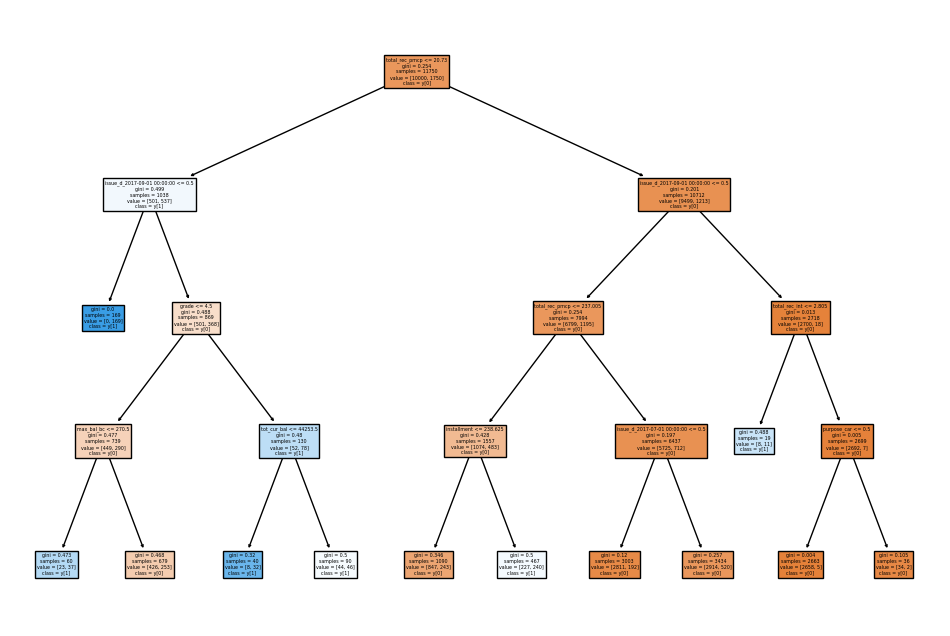

In [15]:
# MODELO Arboles (Natural)

# Uso del modelo de arboles de clasificación
tree_classifier = DecisionTreeClassifier(max_depth=4,min_samples_leaf= 10,random_state=42)
tree_classifier.fit(X, y)

# 10 kf cross validation por accuracy
scores_arboles = cross_val_score(tree_classifier, X, y, cv=10)
scores_promedio_arboles = scores_arboles.mean()

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_ar = cross_val_score(tree_classifier, X, y, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"La precisión del árbol de clasificación a través de 10 fold CV fue de: {scores_promedio_arboles * 100:.2f}%")
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_ar.mean()* 100:.2f}%")

# Gráfica de los arboles de decisión
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier, filled=True, feature_names=X.columns, class_names=True)
plt.show()

#### Árboles de clasificación con la muestra rebalanceada

In [16]:
# MODELO ARBOLES (Rebalanceado)

# Uso del modelo de arboles de clasificación
tree_classifier = DecisionTreeClassifier(max_depth=4,min_samples_leaf= 10,random_state=42)
tree_classifier.fit(X_resampled, y_resampled)

# 10 kf cross validation por accuracy
scores_arboles = cross_val_score(tree_classifier, X_resampled, y_resampled, cv=10)
scores_promedio_arboles = scores_arboles.mean()

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_ar = cross_val_score(tree_classifier, X_resampled, y_resampled, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"La precisión del árbol de clasificación a través de 10 fold CV fue de: {scores_promedio_arboles * 100:.2f}%")
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_ar.mean()* 100:.2f}%")


La precisión del árbol de clasificación a través de 10 fold CV fue de: 73.27%
El resultado de precisión a través de Presicion por 10 fold CV fue: 78.29%


### 1.3 5-NN

Para el desarrollo del modelo 5-NN se implementó una medida adicional de precisión: La matriz de confusión. Esto se realiza dado qué se quiere revisar a través de este modelo, cuantos falsos positivos y falsos negativos se pueden llegar a obtener, esto para comparar el resultado entre muestras.

#### 5-NN Para la muestra sin rebalancear

In [50]:
# MODELO 5-NN (Sin rebalancear)

# Dividir los datos en entrenamiento (80%) y prueba (20%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar el modelo k-NN con k=5
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X, y, cv=10)

# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Se definen las posiciones en la matriz de confusión
tn = confusion[0, 0] #Verdaderos negativos
fn = confusion[1, 0] #falsos negativos
fp = confusion[0, 1] #falsos positivos
tp = confusion[1, 1] #Verdaderos positivos

sensitividad = tp / (tp + fp) #sensitividad
especificidad = tn / (tn + fn) #especificidad
fal_neg = fn / (fn + tn)
fal_pos = fp / (fp + tp)

# Resultados
print("Matriz de Confusión:")
print(confusion)
print("Sensitividad:", sensitividad)
print("Especificidad:", especificidad)
print("Falsos Positivos:", fal_pos)
print("Falsos Negativos:", fal_neg)
print("Precisión promedio:", scores.mean())

Matriz de Confusión:
[[1939   61]
 [ 339   11]]
Sensitividad: 0.1527777777777778
Especificidad: 0.8511852502194908
Falsos Positivos: 0.8472222222222222
Falsos Negativos: 0.1488147497805092
Precisión promedio: 0.8284255319148937


#### 5-NN Para la muestra rebalanceada

In [51]:
# 5-NN con la muestra rebalanceda

# Dividir los datos en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=5
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# predicción
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_resampled, y_resampled, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_resampled, y_resampled, cv=10, scoring=precision_scorer)

# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

tn = confusion[0, 0]  # Verdaderos negativos
fn = confusion[1, 0]  # Falsos negativos
fp = confusion[0, 1]  # Falsos positivos
tp = confusion[1, 1]  # Verdaderos positivos

sensitividad = tp / (tp + fp)  # Sensitividad
especificidad = tn / (tn + fn)  # Especificidad
fal_neg = fn / (fn + tn)
fal_pos = fp / (fp + tp)

# Resultados
print("Matriz de Confusión:")
print(confusion)
print("Sensitividad:", sensitividad)
print("Especificidad:", especificidad)
print("Falsos Positivos:", fal_pos)
print("Falsos Negativos:", fal_neg)
print("Precisión promedio:", scores.mean())
print("Precisión: ", puntuaciones_precision.mean())

Matriz de Confusión:
[[577 301]
 [278 301]]
Sensitividad: 0.5
Especificidad: 0.6748538011695906
Falsos Positivos: 0.5
Falsos Negativos: 0.32514619883040935
Precisión promedio: 0.6090821387117684
Precisión:  0.5230425099129056


## 2. Selección de 10 variables

Las variables seleccionadas bajo la intuición económicapara el modelo reducido fueron las siguientes:
 - Application Type: La razón por la que se considera importante esta variable se debe a qué una aplicación conjunta puede implicar un efecto más pronunciado en la clasificación, esto dado a qué la responsabilidad financiera pasa a ser compartida, generando un apoyo mutuo en el pago del crédito solicitado. Esto implicaría que las personas que piden el préstamo por su cuenta tienden a correr más peligro dado que el peso de la obligación se vuelve individual.
 - Delinq_2yrs:  Esta variable se considera ya que puede funcionar cómo un indicador de impago en el corto plazo, que puede estar relacionado con individuos que han tenido deudas previas donde han presentado periodos de impago y que actualmente puedan estar buscando una nueva para pagar la que ya tenían presente.
 - Grade: La calificación de riesgo se considera importante ya que indica en base al historial financiero de una persona que tan factible es prestarle dinero. Si esta es considerada por el sistema cómo riesgosa, se asume qué es menos probable prestarle y a su vez, que es más probable que esta caiga en un impago o se vuelva defaulter.
 - Inq_last_12m: Esta variable al igual que “Delinq_2yrs” funciona cómo indicador de riesgo. Al considerar el número de investigaciones financieras que se le han hecho a las personas durante los últimos 12 meses, se puede identificar el número de veces que previamente un individuo ha sido potencialmente rechazado por una entidad financiera, pues tiene en cuenta las veces que este ha acudido a una entidad a solicitar algo y ha sido investigado por eso.
 - Mort_acc: Es importante ya que evalua la capacidad de pago de una persona a través de experiencias previas con hipotecas, además de que tiene en cuenta el número de propiedades que una persona tiene, las cuales bajo las condiciones de la deuda pueden ser consideradas como colaterales qué pueden ayudar a gestionar de manera más segura una deuda.
 - Pub_rec: Al buscar cuantificar esta variable la cantidad de apariciones e historial crediticio negativo como quiebras, demandas, problemas legales, embargos, entre otros; nos parece significativa y diciente esta variable frente a la posibilidad de caer en impago dado el contexto al que se enfrenta el solicitante, ya que al estar en quiebra o embargado pueda que el préstamo sea su solución sin tener las condiciones para cumplir con los pagos de cara al futuro.
 - Total_rec_int: Partiendo de la relación inversa existente entre riesgo y tasa, decidimos agregar esta variable que nos indica los intereses recibidos por la persona. Buscamos mediante esta tasa poder agregarle información al modelo sobre la probabilidad que caiga en impago por la probabilidad teniendo en cuenta que tan alta sea la tasa recibida
 - Term: Teniendo en cuenta que los créditos tienen un plazo de 36 o 60, siendo uno un poco más del doble, nos parece importante incluir esta variable debido a que las condiciones socioeconómicas del solicitante pueden tener cambios fuertes entre un plazo y otro, afectando la capacidad de pago del solicitante. Por lo que esta incertidumbre puede traducirse en aumento en la probabilidad de impago.
 - Verification_status: Decidimos incluirla ya que al no estar verificada la fuente de ingresos no se tiene certeza sobre la veracidad de esta información y la realidad del contexto financiero del solicitante.
 - Annual_inc: Consideramos importante seleccionar el ingreso como una de las variables que puede explicar de mejor manera la variable dependiente debido a que a mayor nivel de ingreso hay más facilidad de mantener ahorros o un “colchon financiero” que permita en momentos de crisis usarlo evitando así caer en impagos. A diferencia de otras situaciones socioeconómicas en la que no se tiene esa capacidad de ahorro por el nivel de ingresos, lo que aumenta la probabilidad de impago. Teniendo en cuenta que la relación ahorro-ingreso no necesariamente es lineal pero que pueda dar mejores indicios a priori sobre la posibilidad de caer en impago.

## 3. Técnicas de ML para modelo reducido

Para poder extraer las variables del modelo reducido se vuelven a importar los datos

In [17]:
# Se extraen nuevamente los datos
datos1 = pd.read_excel('loans.xlsx')

In [18]:
# Se seleccionan las variables que se van a utilizar del modelo de la base de datos inicial
variables = datos1[['loan_status','annual_inc','application_type','delinq_2yrs','grade','inq_last_12m','mort_acc','pub_rec','term','total_rec_int','verification_status']]
datos1 = pd.DataFrame(variables)

# Manejo de variables del modelo reducido

#Para el loan status
dummies_loan = {'Current': 0, 'Fail': 1}
datos1['loan_status'] = datos1['loan_status'].map(dummies_loan)

#Para "Application_type"
dummies_application = {'Individual': 0, 'Joint App':1}
datos1['application_type'] = datos1['application_type'].map(dummies_application)

#Para la calificación de riesgo
num_grade = {'A': 1, 'B': 2, 'C': 3,'D':4,'E':5,'F':6,'G':7}
datos1['grade'] = datos1['grade'].map(num_grade)

#Para la variable "verification"
verification_dummies = pd.get_dummies(datos1['verification_status'], prefix='verification_status')
verification_dummies = verification_dummies.astype(int)
datos1 = pd.concat([datos1, verification_dummies], axis=1)
datos1 = datos1.drop(columns=['verification_status'])


Definición de las variables dependientes e indepenidentes

In [19]:
#Se definen las variables dependientes e independientes
X_red = datos1.iloc[:, 1:]
y_red = datos1.iloc[:, 0]

# Para el modelo reducido rebalanceado
oversampler = RandomOverSampler(sampling_strategy=0.3, random_state=42)
X_resampled_red, y_resampled_red = oversampler.fit_resample(X_red, y_red)

#Undersampling a los 0 (Current) para alcanzar un 70%
undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_resampled_red, y_resampled_red = undersampler.fit_resample(X_resampled_red, y_resampled_red)

### 3.1 Regresión Logística

In [146]:
# MODELO LOGIT (NATURAL)

# Se entrenan los datos para poder obtener coeficientes entrenando al modelo
X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

# Se llama al modelo que se utilizará
logit_reg = LogisticRegression()

# Se entrenan los datos
logit_reg.fit(X_train, y_train)

# Se define el umbral y se predice en base a este umbral, clasificando como 1 a todos los que tengan una prob > 0.85
umbral = 0.85
y_pred_proba = logit_reg.predict_proba(X_test)[:, 1]
y_pred_umbral = (y_pred_proba >= umbral).astype(int)

# Matriz de confusión
confusion = confusion_matrix(y_test, y_pred_umbral)

# Precisión por 10 keyfold cross validation
kf_10_logit = cross_val_score(logit_reg,X_red, y_red, cv=10)

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_logred = cross_val_score(logit_reg, X_red, y_red, cv=10, scoring=precision_scorer)



print(f"Matriz de Confusión:\n{confusion}")
print(f"Precisión del modelo con umbral del {umbral} a través de accuracy: {kf_10_logit.mean()}")
print(f"Precisión del modelo con umbral del {umbral} a  través de precision: {puntuaciones_precision_logred.mean()}")

print("Para el modelo rebalanceado")

Matriz de Confusión:
[[2010    0]
 [ 340    0]]
Precisión del modelo con umbral del 0.85 a través de accuracy: 0.8511489361702129
Precisión del modelo con umbral del 0.85 a  través de precision: 0.1
Para el modelo rebalanceado


#### Modelo Logit Rebalanceado

In [63]:
# Se repite el proceso con un X rebalanceado
X_train, X_test, y_train, y_test = train_test_split(X_resampled_red, y_resampled_red, test_size=0.5, random_state=42)
logit_reg = LogisticRegression()
logit_reg.fit(X_train, y_train)

# Se establece el mismo umbral qué en el modelo sin rebalancear (La idea es comparar)
umbral = 0.85
y_pred_proba = logit_reg.predict_proba(X_test)[:, 1]
y_pred_umbral = (y_pred_proba >= umbral).astype(int)

# Se sobreescribe una matriz de confusión para esta muestra
confusion = confusion_matrix(y_test, y_pred_umbral)
precision = accuracy_score(y_test, y_pred_umbral)

# Precisión por 10 keyfold cross validation
kf_10_logit = cross_val_score(logit_reg,X_resampled_red, y_resampled_red, cv=10)

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_logred = cross_val_score(logit_reg, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

print(f"Matriz de Confusión:\n{confusion}")
print(f"Precisión del modelo con umbral del {umbral} a través de accuracy: {kf_10_logit.mean()}")
print(f"Precisión del modelo con umbral del {umbral} a  través de precision: {puntuaciones_precision_logred.mean()}")


Matriz de Confusión:
[[2156    0]
 [1487    0]]
Precisión del modelo con umbral del 0.85 a través de accuracy: 0.5927297668038408
Precisión del modelo con umbral del 0.85 a  través de precision: 0.10641013292236563


### 3.2 Árboles de clasificación

#### Árboles de clasificación modelo sin rebalancear

La precisión del árbol de clasificación a través de 10 fold CV fue de: 84.56%
El resultado de precisión a través de Presicion por 10 fold CV fue: 52.62%


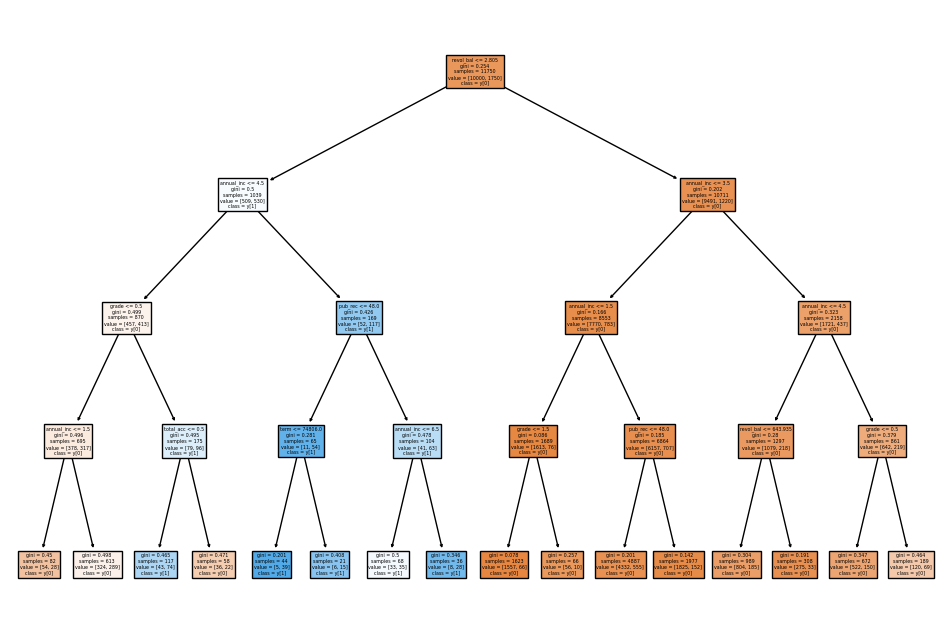

In [64]:
# MODELO Arboles (Natural)

# Se establecen los HP
tree_classifier = DecisionTreeClassifier(max_depth=4,min_samples_leaf= 10,random_state=42)
tree_classifier.fit(X_red, y_red)

# 10 kf cross validation por accuracy
scores_arboles = cross_val_score(tree_classifier, X_red, y_red, cv=10)
scores_promedio_arboles = scores_arboles.mean()

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_ar = cross_val_score(tree_classifier, X_red, y_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"La precisión del árbol de clasificación a través de 10 fold CV fue de: {scores_promedio_arboles * 100:.2f}%")
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_ar.mean()* 100:.2f}%")

# Gráfica de los arboles de decisión
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier, filled=True, feature_names=X.columns, class_names=True)
plt.show()


#### Árboles de clasificación rebalanceado

In [65]:
# MODELO ARBOLES (Rebalanceado)

# Uso del modelo de arboles de clasificación
tree_classifier = DecisionTreeClassifier(max_depth=4,min_samples_leaf= 10,random_state=42)
tree_classifier.fit(X_resampled_red, y_resampled_red)

# 10 kf cross validation por accuracy
scores_arboles = cross_val_score(tree_classifier, X_resampled_red, y_resampled_red, cv=10)
scores_promedio_arboles = scores_arboles.mean()

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_ar = cross_val_score(tree_classifier, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"La precisión del árbol de clasificación a través de 10 fold CV fue de: {scores_promedio_arboles * 100:.2f}%")
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_ar.mean()* 100:.2f}%")

La precisión del árbol de clasificación a través de 10 fold CV fue de: 67.94%
El resultado de precisión a través de Presicion por 10 fold CV fue: 69.22%


### 3.3 KNN

#### 1-NN modelo sin remuestrar

In [70]:
#1-NN
# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 1
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_red, y_red, cv=10)

# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_red, y_red, cv=10, scoring=precision_scorer)

print("Puntuaciones de validación cruzada:", scores)
print("Accurracy promedio:", scores.mean())
print("Precisión promedio", puntuaciones_precision.mean())

Puntuaciones de validación cruzada: [0.77191489 0.79148936 0.75744681 0.7693617  0.7506383  0.76680851
 0.76340426 0.73957447 0.76851064 0.76340426]
Accurracy promedio: 0.7642553191489363
Precisión promedio 0.19782842122819616


#### 1-NN modelo con remuestreo

In [67]:
#1-NN
# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_resampled_red, y_resampled_red, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 1
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_resampled, y_resampled_red, cv=10)

# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

print("Puntuaciones de validación cruzada:", scores)
print("Accurracy promedio:", scores.mean())
print("Precisión promedio", puntuaciones_precision.mean())

Puntuaciones de validación cruzada: [0.69135802 0.69135802 0.70919067 0.68998628 0.69410151 0.67994505
 0.82005495 0.81593407 0.80906593 0.80769231]
Accurracy promedio: 0.7408686820723858
Precisión promedio 0.674029703452834


#### 5-NN modelo sin remuestrar

In [71]:
#5-NN

# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_red, y_red, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_red, y_red, cv=10, scoring=precision_scorer)

print("Puntuaciones de validación cruzada:", scores)
print("Accurracy promedio:", scores.mean())
print("Precisión promedio:", puntuaciones_precision.mean())

Puntuaciones de validación cruzada: [0.83234043 0.8493617  0.84170213 0.83148936 0.83659574 0.84340426
 0.84       0.83489362 0.84170213 0.83319149]
Accurracy promedio: 0.8384680851063828
Precisión promedio: 0.35184969643184194


#### 5-NN modelo remuestrado

In [69]:
#5-NN

# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_resampled_red, y_resampled_red, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_resampled, y_resampled_red, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

print("Puntuaciones de validación cruzada:", scores)
print("Accurracy promedio:", scores.mean())
print("Precisión promedio:", puntuaciones_precision.mean())

Puntuaciones de validación cruzada: [0.55829904 0.57201646 0.59670782 0.56790123 0.58710562 0.60027473
 0.67445055 0.66071429 0.65384615 0.61950549]
Accurracy promedio: 0.6090821387117684
Precisión promedio: 0.5746070224510309


## 4.Selección de variables a través de la estadística

Para la selección de las variables a través de la estadística se utilizaron inicialmente 2 modelos: Logit y Lasso. La razón de esto es que a través del modelo Logit se busca conocer la significancia de las variables del modelo, esto para comparar y dejar con las variables que coincidan con el modelo de Lasso. Después se comprueba con métodos que establecen que K es mejor

#### Modelo Logit

In [73]:
import statsmodels.api as sm

# Se establece el modelo logit en una variable
logit_reg_significacia = LogisticRegression()

#Con las matrices de X y Y creadas previamente revisamos el ajuste del modelo por su resumen
modelo_logit = sm.Logit(y,datos.iloc[:, 1:])
resultado = modelo_logit.fit()
print(resultado.summary())

# Accuracy del modelo
kf_10_logit_ac = cross_val_score(logit_reg_significacia, datos.iloc[:, 1:], y, cv=10)
scores_promedios_logit_ac = np.mean(kf_10_logit_ac)
print(f"La precisión del modelo a través de keyfold fue de : {scores_promedios_logit_ac}")

Optimization terminated successfully.
         Current function value: 0.330783
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                11750
Model:                          Logit   Df Residuals:                    11697
Method:                           MLE   Df Model:                           52
Date:                Sat, 28 Oct 2023   Pseudo R-squ.:                  0.2140
Time:                        23:01:09   Log-Likelihood:                -3886.7
converged:                       True   LL-Null:                       -4945.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
term                                    0.0188      0.004 

#### Modelo Lasso

Para el módelo Lasso, se van a seleccionar únicamente los 10 coeficientes más altos

In [78]:
# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Crea un modelo de regresión Lasso con validación cruzada
lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=10)

# Ajusta el modelo a los datos de entrenamiento
lasso.fit(X_train, y_train)

# Significancia
c = 0 
# Obtén los residuos
residuals = y_train - lasso.predict(X_train)
# Calcula el error estándar de los coeficientes
mse = (residuals ** 2).mean()
se = (mse / ((X_train ** 2).sum(axis=0)) ** 0.5)
# Calcula el estadístico t y el p-valor
t_stat = (lasso.coef_ - c) / se
p_values = 2 * (1 - stats.norm.cdf(abs(t_stat)))

#nivel de significancia
alfa = 0.05
# Encuentra las variables significativas
variables_significativas = list(X_train.columns[p_values < alfa])


# Obtén los coeficientes y nombres de las variables
coefficients = lasso.coef_
variable_names = X_train.columns

# Crea un DataFrame para organizar los coeficientes y nombres de las variables
coefficients_df = pd.DataFrame({'Variable': variable_names, 'Coeficiente': coefficients})

# Ordena el DataFrame por el valor absoluto del coeficiente de mayor a menor
coefficients_df = coefficients_df.reindex(coefficients_df['Coeficiente'].abs().sort_values(ascending=False).index)

# Imprime el DataFrame ordenado
print(coefficients_df)

                               Variable   Coeficiente
41          issue_d_2017-07-01 00:00:00  1.647787e-01
43          issue_d_2017-09-01 00:00:00 -1.418979e-01
2                                 grade  8.261148e-02
13                     application_type  3.162209e-02
45                  purpose_credit_card -2.146148e-02
46           purpose_debt_consolidation -2.034568e-02
33                 pub_rec_bankruptcies -1.613529e-02
47             purpose_home_improvement -1.352410e-02
4                           delinq_2yrs  1.078872e-02
38     verification_status_Not Verified -9.685948e-03
6                        inq_last_6mths  7.184099e-03
20                          open_rv_12m -6.744672e-03
49               purpose_major_purchase  6.290346e-03
37                  home_ownership_RENT -5.283055e-03
21                          open_rv_24m  3.731997e-03
24                          total_cu_tl  3.326489e-03
30                       num_actv_bc_tl -3.274301e-03
7                           

Para complementar y soportar las variables seleccionadas, se hizo uso de Forward Elimination y de Correlación de Pearson

#### Forward Elimination

In [76]:
from scipy.stats import pearsonr
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se crea un conjunto vacio que tendrá las caracteristicas
selected_features = []

# Inicializar el mejor error con un valor alto
best_error = float('inf')

# Inicializar el mejor modelo como None
best_model = None

# Iterar sobre las características
for feature in X.columns:
    # Agregar la característica al conjunto de características seleccionadas
    selected_features.append(feature)

    # Entrenar un modelo con las características seleccionadas
    model = LinearRegression()
    model.fit(X_train[selected_features], y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test[selected_features])

    # Calcular el error (por ejemplo, el error cuadrático medio)
    error = mean_squared_error(y_test, y_pred)

    # Si el error es mejor que el mejor error actual
    if error < best_error:
        best_error = error
        best_model = model

    # Si el error no mejora, retirar la última característica agregada
    else:
        selected_features.remove(feature)

# Al final del bucle, 'selected_features' contendrá las características seleccionadas
print("Características seleccionadas:", selected_features)

Características seleccionadas: ['term', 'installment', 'grade', 'annual_inc', 'delinq_2yrs', 'pub_rec', 'total_acc', 'total_rec_prncp', 'total_rec_int', 'open_act_il', 'open_il_12m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'total_cu_tl', 'inq_last_12m', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_tl', 'pub_rec_bankruptcies', 'total_bc_limit', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'issue_d_2017-07-01 00:00:00', 'issue_d_2017-08-01 00:00:00', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_medical', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation']


#### Correlación de Pearson

In [79]:
# Correlación de pearson

correlations = {}
for column in X.columns:
    correlations[column] = abs(pearsonr(X[column], y)[0])

top_10_variables_pearson = sorted(correlations, key=correlations.get, reverse=True)[:10]

print(top_10_variables_pearson)


['grade', 'issue_d_2017-07-01 00:00:00', 'verification_status_Not Verified', 'issue_d_2017-09-01 00:00:00', 'total_rec_int', 'inq_last_6mths', 'verification_status_Verified', 'total_rec_prncp', 'inq_last_12m', 'total_bc_limit']


## 5.Modelo de Ridge

Ya que para el modelo Ridge se requiere una estandarización de las variables para que queden en la misma magnitud y se tengan en cuenta aquellas con valores más altos, se inicia estandarizando la matriz X

In [30]:
# Estandarización de la variable X: Para que todo esté en una misma magnitud, las variables se estandarizaran

#Para no modificar la variable X inicial, se establece en un data frame aparte
df_x = pd.DataFrame(X)

#Se crea un data frame vacio con el objetivo de guardar las variables estandarizadas
X_estandarizada = pd.DataFrame()

#Función para estandarizar cada columna
def estandarizador(columna):
    prom = columna.mean()
    std_desv = columna.std()
    return (columna - prom) / std_desv

#A través de un "for" se estandariza cada columna guardado cada valor en el df vacio
for columna in df_x.columns:
    X_estandarizada[columna] = estandarizador(df_x[columna])

### 5.1 Modelo de Ridge con todas las variables

#### Selección de lambda

Se realiza un código el cual estima la precisión promedio por 10 kf cv para cada lambda y selecciona aquel que más precisión tenga

In [32]:
# Se establece el rango de los lambda
numeros = list(range(1, 100))

# Definir lambdas
lambdas = numeros

# Crear DataFrame df con X_estandarizada y y
df = pd.concat([y, X_estandarizada], axis=1)

# Inicializar lista para almacenar los resultados
resultados = []

# Definir el número de folds
num_folds = 10
tamaño_fold = len(df) // num_folds

# Loop sobre lambdas
for lmbda in lambdas:
    # Inicializar lista para almacenar los accuracies de cada fold
    accuracies = []

    # Loop sobre los folds
    for i in range(num_folds):
        # Definir los índices de test y train
        inicio_test = i * tamaño_fold
        fin_test = (i + 1) * tamaño_fold

        # Obtener los datos de test y train
        df_test = df.iloc[inicio_test:fin_test]
        df_train = pd.concat([df.iloc[:inicio_test], df.iloc[fin_test:]])

        # Obtener y_train, X_train, y_test, X_test
        y_train = df_train.iloc[:, 0]
        X_train = df_train.iloc[:, 1:]
        y_test = df_test.iloc[:, 0]
        X_test = df_test.iloc[:, 1:]

        # Calcular el beta
        X_T = np.transpose(X_train)
        X_T_X = np.dot(X_T, X_train) + lmbda*np.identity(X_train.shape[1])
        X_T_X_inv = np.linalg.inv(X_T_X)
        X_T_Y = np.dot(X_T, y_train)
        Beta_train = np.dot(X_T_X_inv, X_T_Y)

        # Calcular y_predict
        y_predict = np.dot(X_test, Beta_train)
        y_predict = np.where(y_predict < 0.85, 0, y_predict)
        y_predict = np.where(y_predict > 0.85, 1, y_predict)

        # Calcular accuracy
        accuracy = np.mean(y_predict == y_test)
        accuracies.append(accuracy)

        # 10 kf cross validation por precision
        precision_scorer = make_scorer(precision_score, greater_is_better=True)
        puntuaciones_precision_ar = cross_val_score(tree_classifier, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

    # Calcular el promedio de accuracies
    accuracy_promedio = np.mean(accuracies)

    # Almacenar el resultado
    resultados.append((lmbda, accuracy_promedio))

# Convertir resultados a DataFrame
resultados_df = pd.DataFrame(resultados, columns=['Lambda', 'Accuracy Promedio'])

# Se establece un índice que tendrá en cuenta cual es el mayor accuracy promedio entre todos los lambdas
indice_max = np.argmax(resultados_df['Accuracy Promedio'])

# Se encuentra el lambda respectivo al índice que tiene el mayor accuracy
lambda_pro = resultados_df.loc[indice_max, 'Lambda']
accuracy_pro = resultados_df.loc[indice_max, 'Accuracy Promedio']


# Imprimir resultados
print(resultados_df)
print(f"El lambda del modelo con las variables completas es: {lambda_pro} con un accuray de :{accuracy_pro}")

    Lambda  Accuracy Promedio
0        1           0.851574
1        2           0.851574
2        3           0.851574
3        4           0.851574
4        5           0.851574
..     ...                ...
94      95           0.851574
95      96           0.851574
96      97           0.851574
97      98           0.851574
98      99           0.851574

[99 rows x 2 columns]
El lambda del modelo con las variables completas es: 23 con un accuray de :0.851659574468085


### 5.2 Modelo con 10 variables 

Para la selección de las 10 variables se propone la realización de una combinación entre todas las variables en grupos de a 10, buscando cual proporciona un mayor accuracy a través de 10 keyfold cv

A través de la libreria "itertools" se realizan combinaciones de a 10 para todas las columnas de la matriz "X"

In [ ]:
#(NO CORRER)
import itertools
import pandas as pd
import numpy as np

# Todas las combinaciones de 10 variables
combinaciones = list(itertools.combinations(X.columns, 5))

# Se establecen valores vacios para reemplazarlos en el "for"
mejor_conjunto = None
mejor_lambda = None
mejor_accuracy = 0

A través de un "for" se empieza una iteración para cada grupo de 10 variables. En cada una de estas se se calcula el lambda óptimo junto a su precisión; aquel modelo qué proporcione el accuracy más alto será el que tendrá las mejores variables para el modelo.

In [ ]:
# NO CORRER X2

# Iterar sobre todas las combinaciones
for combo in combinaciones:
    # Lista de variables por iteración
    X_subset = X[list(combo)]

    # Se establece el rango de los lambda
    numeros = list(range(1, 100))
    lambdas = numeros

    df = pd.concat([y, X_subset], axis=1)

    resultados = []

    num_folds = 10
    tamaño_fold = len(df) // num_folds

    for lmbda in lambdas:
        accuracies = []

        for i in range(num_folds):
            inicio_test = i * tamaño_fold
            fin_test = (i + 1) * tamaño_fold

            df_test = df.iloc[inicio_test:fin_test]
            df_train = pd.concat([df.iloc[:inicio_test], df.iloc[fin_test:]])

            y_train = df_train.iloc[:, 0]
            X_train = df_train.iloc[:, 1:]
            y_test = df_test.iloc[:, 0]
            X_test = df_test.iloc[:, 1:]

            X_T = np.transpose(X_train)
            X_T_X = np.dot(X_T, X_train) + lmbda*np.identity(X_train.shape[1])
            X_T_X_inv = np.linalg.inv(X_T_X)
            X_T_Y = np.dot(X_T, y_train)
            Beta_train = np.dot(X_T_X_inv, X_T_Y)

            y_predict = np.dot(X_test, Beta_train)
            y_predict = np.where(y_predict < 0.85, 0, y_predict)
            y_predict = np.where(y_predict > 0.85, 1, y_predict)

            accuracy = np.mean(y_predict == y_test)
            accuracies.append(accuracy)

        accuracy_promedio = np.mean(accuracies)

        resultados.append((lmbda, accuracy_promedio))

    resultados_df = pd.DataFrame(resultados, columns=['Lambda', 'Accuracy Promedio'])

    indice_max = np.argmax(resultados_df['Accuracy Promedio'])

    lambda_pro = resultados_df.loc[indice_max, 'Lambda']
    accuracy_pro = resultados_df.loc[indice_max, 'Accuracy Promedio']

    if accuracy_pro > mejor_accuracy:
        mejor_conjunto = combo
        mejor_lambda = lambda_pro
        mejor_accuracy = accuracy_pro


print(f"El mejor conjunto de variables es: {mejor_conjunto}")
print(f"El lambda asociado es: {mejor_lambda}")
print(f"Con un accuray de: {mejor_accuracy}")

Ya que el proceso de buscar el grupo de mejores variables es computacionalmente costoso, se decide revisar el modelo de Ridge para el modelo reducido; esto ya qué comparte intuición económica y tienen componentes que son estadísticamente mejores.

### 5.2.1 Modelo reducido con 10 variables 

Se estandarizan las variables de la matriz X

In [22]:
# Estandarización de la variable X que cuenta con los 10 determinantes
df_x_red = pd.DataFrame(X_red)

#Se crea un data frame vacio con el objetivo de guardar las variables estandarizadas del modelo reducido
X_estandarizada_red = pd.DataFrame()

for columna in df_x_red.columns:
    X_estandarizada_red[columna] = estandarizador(df_x_red[columna])

A través del comando directo se busca cuaal es el lambda óptimo

In [28]:
# Se establecen los posibles lambdas
alphas = list(range(1,1000)) 

# Se un modelo de RidgeCV que selecciona automáticamente el mejor alpha
ridge_cv = RidgeCV(alphas=alphas)

# A través de un CV se entrena el modelo buscando encontrar cual es el lambda que hace parte del proceso
ridge_cv.fit(X_estandarizada_red, y_red)

# El valor óptimo de alpha
alpha_optimo = ridge_cv.alpha_

print(f'El valor óptimo de alpha es: {alpha_optimo}')

El valor óptimo de alpha es: 58


In [37]:
# Dado que ya tenemos el lambda, calculamos el accuracy del modelo
lambda1 = 58
num_folds = 10


df = pd.concat([y_red, X_estandarizada_red], axis=1)
tamaño_fold = len(df) // num_folds
accuracies = []


# Loop sobre los folds
for i in range(num_folds):
  # Definir los índices de test y train
  inicio_test = i * tamaño_fold
  fin_test = (i + 1) * tamaño_fold

  # Obtener los datos de test y train
  df_test = df.iloc[inicio_test:fin_test]
  df_train = pd.concat([df.iloc[:inicio_test], df.iloc[fin_test:]])

  # Obtener y_train, X_train, y_test, X_test
  y_train = df_train.iloc[:, 0]
  X_train = df_train.iloc[:, 1:]
  y_test = df_test.iloc[:, 0]
  X_test = df_test.iloc[:, 1:]

  # Calcular el beta
  X_T = np.transpose(X_train)
  X_T_X = np.dot(X_T, X_train) + lambda1*np.identity(X_train.shape[1])
  X_T_X_inv = np.linalg.inv(X_T_X)
  X_T_Y = np.dot(X_T, y_train)
  Beta_train = np.dot(X_T_X_inv, X_T_Y)

  # Calcular y_predict
  y_predict = np.dot(X_test, Beta_train)
  y_predict = np.where(y_predict < 0.85, 0, y_predict)
  y_predict = np.where(y_predict > 0.85, 1, y_predict)

  # Calcular accuracy
  accuracy = np.mean(y_predict == y_test)
  accuracies.append(accuracy)

# Calcular el promedio de accuracies
accuracy_promedio = np.mean(accuracies)
print(f"El accuracy del modelo un un lambda de: {lambda1} es de {accuracy_promedio}")

El accuracy del modelo un un lambda de: 58 es de 0.851063829787234


## 6. Modelo Ridge

Se seleccionan nuevamente las variables pertenecientes al modelo de Ridge aplicando los respectivos cambios a las variables

In [38]:
datos2 = pd.read_excel('loans.xlsx')

#Combinando ML y Economía seleccionamos las siguientes variables:
variables1 = datos2[['loan_status','application_type','delinq_2yrs','grade','inq_last_6mths','term','total_rec_prncp','pub_rec_bankruptcies','total_rec_int','total_cu_tl','total_bc_limit']]
datos2= pd.DataFrame(variables1)


# Manejo de variables del modelo de ML y economía

#Para el loan status
dummies_loan = {'Current': 0, 'Fail': 1}
datos2['loan_status'] = datos2['loan_status'].map(dummies_loan)

#Para "Application_type"
dummies_application = {'Individual': 0, 'Joint App':1}
datos2['application_type'] = datos2['application_type'].map(dummies_application)

#Para la calificación de riesgo "grade"
num_grade_dummies = pd.get_dummies(datos2['grade'], prefix='grade')
num_grade_dummies = num_grade_dummies.astype(int)
datos2 = pd.concat([datos2, num_grade_dummies], axis=1)
datos2 = datos2.drop(columns=['grade'])

Se definen las variables dependientes e independientes del modelo Ridge

In [39]:
#Se definen las variables dependientes e independientes
X_pro = datos2.iloc[:, 1:]
y_pro = datos2.iloc[:, 0]

#Estandarización de la variable X
df_x_pro = pd.DataFrame(X_pro)
#Se crea un data frame vacio con el objetivo de guardar las variables estandarizadas del modelo reducido
X_estandarizada_pro = pd.DataFrame()

for columna in df_x_pro.columns:
    X_estandarizada_pro[columna] = estandarizador(df_x_pro[columna])

### 6.1 Metodología Ridge para el modelo Ridge

Se busca el lambda óptimo para el modelo Ridge

In [41]:
# Se establecen los lambdas
alphas = list(range(1,1000))  # Puedes ajustar el rango según sea necesario

# Crear un modelo de RidgeCV que selecciona automáticamente el mejor alpha
ridge_cv = RidgeCV(alphas=alphas)

# Realizar la validación cruzada para encontrar el mejor alpha
ridge_cv.fit(X_estandarizada_pro, y_pro)

# El valor óptimo de alpha
alpha_optimo = ridge_cv.alpha_

print(f'El valor óptimo de alpha es: {alpha_optimo}')

El valor óptimo de alpha es: 98


En base al lambda calculado se calcula el accuracy del modelo para las variables del modelo ridge

In [42]:
# Dado que ya tenemos el lambda, calculamos el accuracy del modelo
lambda1 = 98
num_folds = 10
tamaño_fold = len(df) // num_folds

df = pd.concat([y_pro, X_estandarizada_pro], axis=1)
accuracies = []


# Loop sobre los folds
for i in range(num_folds):
  # Definir los índices de test y train
  inicio_test = i * tamaño_fold
  fin_test = (i + 1) * tamaño_fold

  # Obtener los datos de test y train
  df_test = df.iloc[inicio_test:fin_test]
  df_train = pd.concat([df.iloc[:inicio_test], df.iloc[fin_test:]])

  # Obtener y_train, X_train, y_test, X_test
  y_train = df_train.iloc[:, 0]
  X_train = df_train.iloc[:, 1:]
  y_test = df_test.iloc[:, 0]
  X_test = df_test.iloc[:, 1:]

  # Calcular el beta
  X_T = np.transpose(X_train)
  X_T_X = np.dot(X_T, X_train) + lambda1*np.identity(X_train.shape[1])
  X_T_X_inv = np.linalg.inv(X_T_X)
  X_T_Y = np.dot(X_T, y_train)
  Beta_train = np.dot(X_T_X_inv, X_T_Y)

  # Calcular y_predict
  y_predict = np.dot(X_test, Beta_train)
  y_predict = np.where(y_predict < 0.85, 0, y_predict)
  y_predict = np.where(y_predict > 0.85, 1, y_predict)

  # Calcular accuracy
  accuracy = np.mean(y_predict == y_test)
  accuracies.append(accuracy)

# Calcular el promedio de accuracies
accuracy_promedio = np.mean(accuracies)
print(f"El accuracy del modelo un un lambda de: {lambda1} es de {accuracy_promedio}")

El accuracy del modelo un un lambda de: 98 es de 0.851063829787234


Estas variables son esenciales para clasificar "alarmas" que pueden indicar la probabilidad de un cliente de pagar o no. Se basan principalmente en los límites financieros del individuo y en señales de riesgo previas reportadas en el sistema financiero. Además, estas variables están directamente relacionadas con la teoría económica y reflejan los elementos que se buscaban representar en el modelo inicial de las 10 variables. Dado esto, las variables representan en su totalidad un resultado esperado.

## 7. ML para modelo reducido

### 7.1 Regresión ridge

In [46]:
# Establecer los lambdas
alphas = list(range(1, 1000))

# Crear un modelo de RidgeCV que selecciona automáticamente el mejor alpha
ridge_cv = RidgeCV(alphas=alphas)

# Realizar la validación cruzada para encontrar el mejor alpha
ridge_cv.fit(X_estandarizada_red, y_red)

# El valor óptimo de alpha
alpha_optimo = ridge_cv.alpha_

print(f'El valor óptimo de alpha es: {alpha_optimo}')

El valor óptimo de alpha es: 58


Se busca la precisión con el lambda óptimo

In [48]:
# Dado que ya tenemos el lambda, calculamos el accuracy del modelo

lambda1 = 58
num_folds = 10
tamaño_fold = len(df) // num_folds

df = pd.concat([y_red, X_estandarizada_red], axis=1)
accuracies = []


# Loop sobre los folds
for i in range(num_folds):
  # Definir los índices de test y train
  inicio_test = i * tamaño_fold
  fin_test = (i + 1) * tamaño_fold

  # Obtener los datos de test y train
  df_test = df.iloc[inicio_test:fin_test]
  df_train = pd.concat([df.iloc[:inicio_test], df.iloc[fin_test:]])

  # Obtener y_train, X_train, y_test, X_test
  y_train = df_train.iloc[:, 0]
  X_train = df_train.iloc[:, 1:]
  y_test = df_test.iloc[:, 0]
  X_test = df_test.iloc[:, 1:]

  # Calcular el beta
  X_T = np.transpose(X_train)
  X_T_X = np.dot(X_T, X_train) + lambda1*np.identity(X_train.shape[1])
  X_T_X_inv = np.linalg.inv(X_T_X)
  X_T_Y = np.dot(X_T, y_train)
  Beta_train = np.dot(X_T_X_inv, X_T_Y)

  # Calcular y_predict
  y_predict = np.dot(X_test, Beta_train)
  y_predict = np.where(y_predict < 0.85, 0, y_predict)
  y_predict = np.where(y_predict > 0.85, 1, y_predict)

  # Calcular accuracy
  accuracy = np.mean(y_predict == y_test)
  accuracies.append(accuracy)

# Calcular el promedio de accuracies
accuracy_promedio = np.mean(accuracies)
print(f"El accuracy del modelo un un lambda de: {lambda1} es de {accuracy_promedio}")

El accuracy del modelo un un lambda de: 58 es de 0.851063829787234


### 7.2 Regresión QDA

#### 7.2.1 QDA para muestra sin rebalancear

In [56]:
# Para muestra sin rebalancear
qda = QuadraticDiscriminantAnalysis()

# Por 10 keyfold cv
cv_scores_qda = cross_val_score(qda, X_red, y_red, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por qda es de : {cv_scores_qda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(qda, X_red, y_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por qda es de : 78.37%
El resultado de precisión a través de Presicion por 10 fold CV fue: 26.16%


#### 7.2.2 QDA para muestra rebalanceada

In [55]:
# Para muestra rebalanceada
qda = QuadraticDiscriminantAnalysis()

# Por 10 keyfold cv
cv_scores_qda = cross_val_score(qda, X_resampled_red, y_resampled_red, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por qda es de : {cv_scores_qda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(qda, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por qda es de : 58.23%
El resultado de precisión a través de Presicion por 10 fold CV fue: 51.96%


### 7.3 Regresión LDA

### 7.3.1 Regresión LDA con muestra sin rebalancear

In [60]:
lda = LinearDiscriminantAnalysis()

# Realización de validación cruzada
cv_scores_lda = cross_val_score(lda, X_red, y_red, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por lda es de : {cv_scores_lda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(lda, X_red, y_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por lda es de : 84.80%
El resultado de precisión a través de Presicion por 10 fold CV fue: 51.19%


### 7.3.2 Regresión LDA con muestra rebalanceada

In [62]:
lda = LinearDiscriminantAnalysis()

# Realización de validación cruzada
cv_scores_lda = cross_val_score(lda, X_resampled_red, y_resampled_red, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por lda es de : {cv_scores_lda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(lda, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por lda es de : 63.69%
El resultado de precisión a través de Presicion por 10 fold CV fue: 58.27%


### 7.4 Logistic Regression

### 7.4.1 Logistic Regression para muestra sin rebalancear

In [78]:
logistic_regression = LogisticRegression(max_iter=1000)

# Realizar validación cruzada
cv_scores_lr = cross_val_score(logistic_regression, X_red, y_red, cv=10, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print(f"El accuracy del modelo reducido por logitic regression es de : {cv_scores_lr.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(logistic_regression, X_red, y_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por logitic regression es de : 85.11%
El resultado de precisión a través de Presicion por 10 fold CV fue: 10.00%


### 7.4.2 Logistic Regression para muestra rebalanceada

In [79]:
logistic_regression = LogisticRegression(max_iter=1000)

# Realizar validación cruzada
cv_scores_lr = cross_val_score(logistic_regression, X_resampled_red, y_resampled_red, cv=10, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print(f"El accuracy del modelo reducido por logitic regression es de : {cv_scores_lr.mean()* 100:.2f}%")


# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(logistic_regression, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por logitic regression es de : 59.27%
El resultado de precisión a través de Presicion por 10 fold CV fue: 10.64%


### 7.5 Gradient Boosting

### 7.5.1 Gradient Boosting Modelo sin remuestrear

In [ ]:
# No correr - Se demora mucho 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Modelo a usar e hiperparametros a calibrar
model = xgb.XGBClassifier()  # Usar XGBoost para clasificación
param_grid = {
    'n_estimators': list(range(1, 101)),            # Números de 1 a 100
    'learning_rate': [0.01 * i for i in range(1, 11)],  # Tasa de aprendizaje de 0.01 a 0.1 en saltos de 0.01
    'max_depth': list(range(1, 6))               # Profundidad máxima de 1 a 5
}

# Crea un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Realiza la validación cruzada k-fold con búsqueda de cuadrícula (Grid Search)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Divide tus datos en características (X) y etiquetas (y) de entrenamiento
X_train, y_train = X_red, y_red

# Ajusta el modelo a los datos de entrenamiento y encuentra los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Puedes acceder al mejor modelo entrenado a través de grid_search.best_estimator_
best_model = grid_search.best_estimator_

# Ahora puedes usar el mejor modelo para hacer predicciones en datos no vistos
X_test, y_test = x, y
predictions = best_model.predict(X_test)

# Evalúa el rendimiento del mejor modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo:", accuracy)


### 7.5.1 Gradient Boosting Modelo rebalanceado

In [ ]:
# No correr - Se demora mucho 

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Modelo a usar e hiperparametros a calibrar
model = xgb.XGBClassifier()  # Usar XGBoost para clasificación
param_grid = {
    'n_estimators': list(range(1, 101)),            # Números de 1 a 100
    'learning_rate': [0.01 * i for i in range(1, 11)],  # Tasa de aprendizaje de 0.01 a 0.1 en saltos de 0.01
    'max_depth': list(range(1, 6))               # Profundidad máxima de 1 a 5
}

# Crea un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Realiza la validación cruzada k-fold con búsqueda de cuadrícula (Grid Search)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Divide tus datos en características (X) y etiquetas (y) de entrenamiento
X_train, y_train = X_resampled_red, y_resampled_red

# Ajusta el modelo a los datos de entrenamiento y encuentra los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Puedes acceder al mejor modelo entrenado a través de grid_search.best_estimator_
best_model = grid_search.best_estimator_

# Ahora puedes usar el mejor modelo para hacer predicciones en datos no vistos
X_test, y_test = x, y
predictions = best_model.predict(X_test)

# Evalúa el rendimiento del mejor modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo:", accuracy)


### 7.6 Random Forest

### 7.6.1 Random Forest con modelo sin rebalancear

In [84]:
# Inicializar el modelo Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
# n_estimators es el número de árboles en el bosque

# Realizar validación cruzada
cv_scores = cross_val_score(random_forest, X_red, y_red, cv=10, scoring='accuracy')  # 5-fold cross-validation

# Imprimir los resultados de la validación cruzada
print(f"La precisión del modelo reducido por random forest: {cv_scores.mean():.4f}")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(random_forest, X_red, y_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

La precisión del modelo reducido por random forest: 0.8283
El resultado de precisión a través de Presicion por 10 fold CV fue: 39.28%


### 7.6.2 Random Forest con modelo rebalanceado

In [85]:
# Inicializar el modelo Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
# n_estimators es el número de árboles en el bosque

# Realizar validación cruzada
cv_scores = cross_val_score(random_forest, X_resampled_red, y_resampled_red, cv=10, scoring='accuracy')  # 5-fold cross-validation

# Imprimir los resultados de la validación cruzada
print(f"La precisión del modelo reducido por random forest: {cv_scores.mean():.4f}")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(random_forest, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

La precisión del modelo reducido por random forest: 0.8381
El resultado de precisión a través de Presicion por 10 fold CV fue: 80.18%


### 7.7 SVM

### 7.7.1 SVM con modelo sin rebalancear

In [ ]:
# Define un rango de hiperparametros a optimizar (C y kernel)
param_dist = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

# Tomar un subconjunto de los datos para la búsqueda inicial
subset_size = 500  # Define el tamaño del subconjunto
X_subset, _, y_subset, _ = train_test_split(X_red, y_Red, train_size=subset_size, random_state=42)

# Crear un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dividir los datos en un conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Modelo a usar (SVM) e hiperparámetros a calibrar
model = SVC()

# Realizar la validación cruzada k-fold con búsqueda aleatoria (Randomized Search)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=kf, scoring='accuracy', n_jobs=-1, n_iter=6)

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
# Puedes acceder al mejor modelo entrenado a través de random_search.best_estimator_
best_model = random_search.best_estimator_

# Usar el mejor modelo para hacer predicciones en datos de prueba
predictions = best_model.predict(X_test)

# Evaluar el rendimiento del mejor modelo en datos de prueba
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo en datos de prueba:", accuracy)


### 7.7.2 SVM con modelo rebalanceado

In [ ]:
# Define un rango de hiperparametros a optimizar (C y kernel)
param_dist = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

# Tomar un subconjunto de los datos para la búsqueda inicial
subset_size = 500  # Define el tamaño del subconjunto
X_subset, _, y_subset, _ = train_test_split(X_resampled_red, y_resampled_Red, train_size=subset_size, random_state=42)

# Crear un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dividir los datos en un conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Modelo a usar (SVM) e hiperparámetros a calibrar
model = SVC()

# Realizar la validación cruzada k-fold con búsqueda aleatoria (Randomized Search)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=kf, scoring='accuracy', n_jobs=-1, n_iter=6)

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
# Puedes acceder al mejor modelo entrenado a través de random_search.best_estimator_
best_model = random_search.best_estimator_

# Usar el mejor modelo para hacer predicciones en datos de prueba
predictions = best_model.predict(X_test)

# Evaluar el rendimiento del mejor modelo en datos de prueba
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo en datos de prueba:", accuracy)


### 7.8 KNN

### 7.8.1 5NN para muestra sin rebalancear

In [91]:
#5-NN

# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_red, y_red, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_red, y_red, cv=10, scoring=precision_scorer)

print("Accurracy promedio:", scores.mean())
print("Precisión promedio:", puntuaciones_precision.mean())

Accurracy promedio: 0.8384680851063828
Precisión promedio: 0.35184969643184194


### 7.8.2 5NN para muestra rebalanceada

In [93]:
#5-NN

# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_resampled_red, y_resampled_red, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_resampled, y_resampled_red, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_resampled_red, y_resampled_red, cv=10, scoring=precision_scorer)

print("Accurracy promedio:", scores.mean())
print("Precisión promedio:", puntuaciones_precision.mean())

Accurracy promedio: 0.6090821387117684
Precisión promedio: 0.5746070224510309


## 8. ML para modelo ridge

### 8.1 Regresión ridge

In [95]:
# Establecer los lambdas
alphas = list(range(1, 1000))

# Crear un modelo de RidgeCV que selecciona automáticamente el mejor alpha
ridge_cv = RidgeCV(alphas=alphas)

# Realizar la validación cruzada para encontrar el mejor alpha
ridge_cv.fit(X_estandarizada_pro, y_pro)

# El valor óptimo de alpha
alpha_optimo = ridge_cv.alpha_

print(f'El valor óptimo de alpha es: {alpha_optimo}')

El valor óptimo de alpha es: 98


In [96]:
# Dado que ya tenemos el lambda, calculamos el accuracy del modelo

lambda1 = 58
num_folds = 10
tamaño_fold = len(df) // num_folds

df = pd.concat([y_red, X_estandarizada_pro], axis=1)
accuracies = []


# Loop sobre los folds
for i in range(num_folds):
  # Definir los índices de test y train
  inicio_test = i * tamaño_fold
  fin_test = (i + 1) * tamaño_fold

  # Obtener los datos de test y train
  df_test = df.iloc[inicio_test:fin_test]
  df_train = pd.concat([df.iloc[:inicio_test], df.iloc[fin_test:]])

  # Obtener y_train, X_train, y_test, X_test
  y_train = df_train.iloc[:, 0]
  X_train = df_train.iloc[:, 1:]
  y_test = df_test.iloc[:, 0]
  X_test = df_test.iloc[:, 1:]

  # Calcular el beta
  X_T = np.transpose(X_train)
  X_T_X = np.dot(X_T, X_train) + lambda1*np.identity(X_train.shape[1])
  X_T_X_inv = np.linalg.inv(X_T_X)
  X_T_Y = np.dot(X_T, y_train)
  Beta_train = np.dot(X_T_X_inv, X_T_Y)

  # Calcular y_predict
  y_predict = np.dot(X_test, Beta_train)
  y_predict = np.where(y_predict < 0.85, 0, y_predict)
  y_predict = np.where(y_predict > 0.85, 1, y_predict)

  # Calcular accuracy
  accuracy = np.mean(y_predict == y_test)
  accuracies.append(accuracy)

# Calcular el promedio de accuracies
accuracy_promedio = np.mean(accuracies)
print(f"El accuracy del modelo un un lambda de: {lambda1} es de {accuracy_promedio}")

El accuracy del modelo un un lambda de: 58 es de 0.851063829787234


### 8.2 Regresión QDA

#### 8.2.1 QDA para muestra sin rebalancear

In [139]:

qda = QuadraticDiscriminantAnalysis()

# Por 10 keyfold cv
cv_scores_qda = cross_val_score(qda, X_pro, y_pro, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por qda es de : {cv_scores_qda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(qda, X_pro, y_pro, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por qda es de : 81.08%
El resultado de precisión a través de Presicion por 10 fold CV fue: 32.58%


#### 8.2.2 QDA para muestra rebalanceado

In [104]:
oversampler = RandomOverSampler(sampling_strategy=0.3, random_state=42)
X_resampled_pro, y_resampled_pro = oversampler.fit_resample(X_pro, y_pro)

# Eliminar filas con valores NaN en y_resampled_pro
resampled_data = pd.concat([X_resampled_pro, y_resampled_pro], axis=1)
resampled_data = resampled_data.dropna(subset=[y_resampled_pro.name])

X_resampled_pro = resampled_data.iloc[:, :-1]
y_resampled_pro = resampled_data.iloc[:, -1]

# Undersampling a los 0 (Current) para alcanzar un 70%
undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_resampled_pro, y_resampled_pro = undersampler.fit_resample(X_resampled_pro, y_resampled_pro)

# Para muestra sin rebalancear
qda = QuadraticDiscriminantAnalysis()

# Por 10 keyfold cv
cv_scores_qda = cross_val_score(qda, X_resampled_pro, y_resampled_pro, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por qda es de: {cv_scores_qda.mean() * 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(qda, X_resampled_pro, y_resampled_pro, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Precision por 10 fold CV fue: {puntuaciones_precision_red.mean() * 100:.2f}%")


El accuracy del modelo reducido por qda es de: 62.64%
El resultado de precisión a través de Precision por 10 fold CV fue: 59.57%


### 8.3 Regresión LDA

### 8.3.1 Regresión LDA con muestra sin rebalancear

In [106]:
lda = LinearDiscriminantAnalysis()

# Realización de validación cruzada
cv_scores_lda = cross_val_score(lda, X_pro, y_pro, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por lda es de : {cv_scores_lda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(lda, X_pro, y_pro, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por lda es de : 84.92%
El resultado de precisión a través de Presicion por 10 fold CV fue: 53.00%


### 8.3.2 Regresión LDA con muestra rebalanceada

In [107]:
lda = LinearDiscriminantAnalysis()

# Realización de validación cruzada
cv_scores_lda = cross_val_score(lda, X_resampled_pro, y_resampled_pro, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por lda es de : {cv_scores_lda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(lda, X_resampled_pro, y_resampled_pro, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por lda es de : 65.44%
El resultado de precisión a través de Presicion por 10 fold CV fue: 62.40%


### 8.4 Logistic Regression

### 8.4.1 Logistic Regression para muestra sin rebalancear

In [113]:
logistic_regression = LogisticRegression(max_iter=100)

# Realizar validación cruzada
cv_scores_lr = cross_val_score(logistic_regression, X_pro, y_pro, cv=10, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print(f"El accuracy del modelo reducido por logitic regression es de : {cv_scores_lr.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(logistic_regression, X_pro, y_pro, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por logitic regression es de : 85.10%
El resultado de precisión a través de Presicion por 10 fold CV fue: 0.00%



### 8.4.2 Logistic Regression para muestra rebalanceada


In [114]:

logistic_regression = LogisticRegression(max_iter=1000)

# Realizar validación cruzada
cv_scores_lr = cross_val_score(logistic_regression, X_resampled_pro, y_resampled_pro, cv=10, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print(f"El accuracy del modelo reducido por logitic regression es de : {cv_scores_lr.mean()* 100:.2f}%")


# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(logistic_regression, X_resampled_pro, y_resampled_pro, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")


El accuracy del modelo reducido por logitic regression es de : 60.92%
El resultado de precisión a través de Presicion por 10 fold CV fue: 41.95%


### 8.5 Gradient Boosting

### 8.5.1 Gradient Boosting Modelo sin remuestrear

In [141]:
# No correr - Se demora mucho 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Modelo a usar e hiperparametros a calibrar
model = xgb.XGBClassifier()  # Usar XGBoost para clasificación
param_grid = {
    'n_estimators': list(range(1, 101)),            # Números de 1 a 100
    'learning_rate': [0.01 * i for i in range(1, 11)],  # Tasa de aprendizaje de 0.01 a 0.1 en saltos de 0.01
    'max_depth': list(range(1, 6))               # Profundidad máxima de 1 a 5
}

# Crea un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Realiza la validación cruzada k-fold con búsqueda de cuadrícula (Grid Search)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Divide tus datos en características (X) y etiquetas (y) de entrenamiento
X_train, y_train = X_pro, y_pro

# Ajusta el modelo a los datos de entrenamiento y encuentra los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Puedes acceder al mejor modelo entrenado a través de grid_search.best_estimator_
best_model = grid_search.best_estimator_

# Ahora puedes usar el mejor modelo para hacer predicciones en datos no vistos
X_test, y_test = x, y
predictions = best_model.predict(X_test)

# Evalúa el rendimiento del mejor modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo:", accuracy)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 57}


NameError: name 'x' is not defined

### 8.5.2 Gradient Boosting Modelo rebalanceado

In [ ]:
# No correr - Se demora mucho 

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Modelo a usar e hiperparametros a calibrar
model = xgb.XGBClassifier()  # Usar XGBoost para clasificación
param_grid = {
    'n_estimators': list(range(1, 101)),            # Números de 1 a 100
    'learning_rate': [0.01 * i for i in range(1, 11)],  # Tasa de aprendizaje de 0.01 a 0.1 en saltos de 0.01
    'max_depth': list(range(1, 6))               # Profundidad máxima de 1 a 5
}

# Crea un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Realiza la validación cruzada k-fold con búsqueda de cuadrícula (Grid Search)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Divide tus datos en características (X) y etiquetas (y) de entrenamiento
X_train, y_train = X_resampled_pro, y_resampled_pro

# Ajusta el modelo a los datos de entrenamiento y encuentra los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Puedes acceder al mejor modelo entrenado a través de grid_search.best_estimator_
best_model = grid_search.best_estimator_

# Ahora puedes usar el mejor modelo para hacer predicciones en datos no vistos
X_test, y_test = x, y
predictions = best_model.predict(X_test)

# Evalúa el rendimiento del mejor modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo:", accuracy)

### 8.6 Random Forest

### 8.6.1 Random Forest con modelo sin rebalancear

In [135]:
# Inicializar el modelo Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
# n_estimators es el número de árboles en el bosque

# Realizar validación cruzada
cv_scores = cross_val_score(random_forest, X_pro, y_pro, cv=10, scoring='accuracy')  # 5-fold cross-validation

# Imprimir los resultados de la validación cruzada
print(f"La precisión del modelo reducido por random forest: {cv_scores.mean():.4f}")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(random_forest, X_pro, y_pro, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

La precisión del modelo reducido por random forest: 0.8523
El resultado de precisión a través de Presicion por 10 fold CV fue: 51.77%


### 8.6.2 Random Forest con modelo rebalanceado

In [136]:
# Inicializar el modelo Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
# n_estimators es el número de árboles en el bosque

# Realizar validación cruzada
cv_scores = cross_val_score(random_forest, X_resampled_pro, y_resampled_pro, cv=10, scoring='accuracy')  # 5-fold cross-validation

# Imprimir los resultados de la validación cruzada
print(f"La precisión del modelo reducido por random forest: {cv_scores.mean():.4f}")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(random_forest, X_resampled_pro, y_resampled_pro, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

La precisión del modelo reducido por random forest: 0.8526
El resultado de precisión a través de Presicion por 10 fold CV fue: 81.90%


### 8.7 SVM

### 8.7.1 SVM con modelo sin rebalancear

In [ ]:
# Define un rango de hiperparametros a optimizar (C y kernel)
param_dist = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

# Tomar un subconjunto de los datos para la búsqueda inicial
subset_size = 500  # Define el tamaño del subconjunto
X_subset, _, y_subset, _ = train_test_split(X_pro, y_pro, train_size=subset_size, random_state=42)

# Crear un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dividir los datos en un conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Modelo a usar (SVM) e hiperparámetros a calibrar
model = SVC()

# Realizar la validación cruzada k-fold con búsqueda aleatoria (Randomized Search)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=kf, scoring='accuracy', n_jobs=-1, n_iter=6)

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
# Puedes acceder al mejor modelo entrenado a través de random_search.best_estimator_
best_model = random_search.best_estimator_

# Usar el mejor modelo para hacer predicciones en datos de prueba
predictions = best_model.predict(X_test)

# Evaluar el rendimiento del mejor modelo en datos de prueba
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo en datos de prueba:", accuracy)


### 7.7.2 SVM con modelo rebalanceado

# Define un rango de hiperparametros a optimizar (C y kernel)
param_dist = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

# Tomar un subconjunto de los datos para la búsqueda inicial
subset_size = 500  # Define el tamaño del subconjunto
X_subset, _, y_subset, _ = train_test_split(X_resampled_red, y_resampled_Red, train_size=subset_size, random_state=42)

# Crear un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dividir los datos en un conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Modelo a usar (SVM) e hiperparámetros a calibrar
model = SVC()

# Realizar la validación cruzada k-fold con búsqueda aleatoria (Randomized Search)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=kf, scoring='accuracy', n_jobs=-1, n_iter=6)

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
# Puedes acceder al mejor modelo entrenado a través de random_search.best_estimator_
best_model = random_search.best_estimator_

# Usar el mejor modelo para hacer predicciones en datos de prueba
predictions = best_model.predict(X_test)

# Evaluar el rendimiento del mejor modelo en datos de prueba
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo en datos de prueba:", accuracy)


### 8.7.2 SVM con modelo rebalanceado


In [ ]:
# Define un rango de hiperparametros a optimizar (C y kernel)
param_dist = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

# Tomar un subconjunto de los datos para la búsqueda inicial
subset_size = 500  # Define el tamaño del subconjunto
X_subset, _, y_subset, _ = train_test_split(X_resampled_pro, y_resampled_pro, train_size=subset_size, random_state=42)

# Crear un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dividir los datos en un conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Modelo a usar (SVM) e hiperparámetros a calibrar
model = SVC()

# Realizar la validación cruzada k-fold con búsqueda aleatoria (Randomized Search)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=kf, scoring='accuracy', n_jobs=-1, n_iter=6)

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
# Puedes acceder al mejor modelo entrenado a través de random_search.best_estimator_
best_model = random_search.best_estimator_

# Usar el mejor modelo para hacer predicciones en datos de prueba
predictions = best_model.predict(X_test)

# Evaluar el rendimiento del mejor modelo en datos de prueba
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo en datos de prueba:", accuracy)

### 8.8 KNN

### 8.8.1 5NN para muestra sin rebalancear

In [116]:
#5-NN

# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_pro, y_pro, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_red, y_red, cv=10, scoring=precision_scorer)

print("Accurracy promedio:", scores.mean())
print("Precisión promedio:", puntuaciones_precision.mean())

Accurracy promedio: 0.8394893617021276
Precisión promedio: 0.35184969643184194


### 8.8.2 5NN para muestra rebalanceada

In [117]:
#5-NN

# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_resampled_pro, y_resampled_pro, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_resampled_pro, y_resampled_pro, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_resampled_pro, y_resampled_pro, cv=10, scoring=precision_scorer)

print("Accurracy promedio:", scores.mean())
print("Precisión promedio:", puntuaciones_precision.mean())

Accurracy promedio: 0.6701570720089239
Precisión promedio: 0.598455733210588


## 9. ML para modelo completo


### 9.1 Regresión ridge

In [120]:
#Establecer los lambdas
alphas = list(range(1, 1000))

# Crear un modelo de RidgeCV que selecciona automáticamente el mejor alpha
ridge_cv = RidgeCV(alphas=alphas)

# Realizar la validación cruzada para encontrar el mejor alpha
ridge_cv.fit(X_estandarizada, y)

# El valor óptimo de alpha
alpha_optimo = ridge_cv.alpha_

print(f'El valor óptimo de alpha es: {alpha_optimo}')


El valor óptimo de alpha es: 38


In [121]:
# Dado que ya tenemos el lambda, calculamos el accuracy del modelo

lambda1 = 38
num_folds = 10
tamaño_fold = len(df) // num_folds

df = pd.concat([y, X_estandarizada], axis=1)
accuracies = []


# Loop sobre los folds
for i in range(num_folds):
  # Definir los índices de test y train
  inicio_test = i * tamaño_fold
  fin_test = (i + 1) * tamaño_fold

  # Obtener los datos de test y train
  df_test = df.iloc[inicio_test:fin_test]
  df_train = pd.concat([df.iloc[:inicio_test], df.iloc[fin_test:]])

  # Obtener y_train, X_train, y_test, X_test
  y_train = df_train.iloc[:, 0]
  X_train = df_train.iloc[:, 1:]
  y_test = df_test.iloc[:, 0]
  X_test = df_test.iloc[:, 1:]

  # Calcular el beta
  X_T = np.transpose(X_train)
  X_T_X = np.dot(X_T, X_train) + lambda1*np.identity(X_train.shape[1])
  X_T_X_inv = np.linalg.inv(X_T_X)
  X_T_Y = np.dot(X_T, y_train)
  Beta_train = np.dot(X_T_X_inv, X_T_Y)

  # Calcular y_predict
  y_predict = np.dot(X_test, Beta_train)
  y_predict = np.where(y_predict < 0.85, 0, y_predict)
  y_predict = np.where(y_predict > 0.85, 1, y_predict)

  # Calcular accuracy
  accuracy = np.mean(y_predict == y_test)
  accuracies.append(accuracy)

# Calcular el promedio de accuracies
accuracy_promedio = np.mean(accuracies)
print(f"El accuracy del modelo un un lambda de: {lambda1} es de {accuracy_promedio}")

El accuracy del modelo un un lambda de: 38 es de 0.851659574468085


### 9.2 Regresión QDA


#### 9.2.1 QDA para muestra sin rebalancear


In [122]:
# Para muestra sin rebalancear
qda = QuadraticDiscriminantAnalysis()

# Por 10 keyfold cv
cv_scores_qda = cross_val_score(qda, X, y, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por qda es de : {cv_scores_qda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(qda, X, y, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por qda es de : 78.83%
El resultado de precisión a través de Presicion por 10 fold CV fue: 27.50%


#### 9.2.2 QDA para muestra rebalanceado

In [124]:
# Para muestra sin rebalancear
qda = QuadraticDiscriminantAnalysis()

# Por 10 keyfold cv
cv_scores_qda = cross_val_score(qda, X_resampled, y_resampled, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por qda es de: {cv_scores_qda.mean() * 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(qda, X_resampled, y_resampled, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Precision por 10 fold CV fue: {puntuaciones_precision_red.mean() * 100:.2f}%")


El accuracy del modelo reducido por qda es de: 63.86%
El resultado de precisión a través de Precision por 10 fold CV fue: 63.70%


### 9.3 Regresión LDA

### 9.3.1 Regresión LDA con muestra sin rebalancear

In [126]:
lda = LinearDiscriminantAnalysis()

# Realización de validación cruzada
cv_scores_lda = cross_val_score(lda, X, y, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por lda es de : {cv_scores_lda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(lda, X, y, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")


El accuracy del modelo reducido por lda es de : 85.86%
El resultado de precisión a través de Presicion por 10 fold CV fue: 61.52%


### 9.3.2 Regresión LDA con muestra rebalanceada

In [127]:
lda = LinearDiscriminantAnalysis()

# Realización de validación cruzada
cv_scores_lda = cross_val_score(lda, X_resampled, y_resampled, cv=10, scoring='accuracy')
print(f"El accuracy del modelo reducido por lda es de : {cv_scores_lda.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(lda, X_resampled, y_resampled, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por lda es de : 72.70%
El resultado de precisión a través de Presicion por 10 fold CV fue: 71.06%


### 9.4 Logistic Regression

### 9.4.1 Logistic Regression para muestra sin rebalancear

In [128]:
logistic_regression = LogisticRegression(max_iter=100)

# Realizar validación cruzada
cv_scores_lr = cross_val_score(logistic_regression, X, y, cv=10, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print(f"El accuracy del modelo reducido por logitic regression es de : {cv_scores_lr.mean()* 100:.2f}%")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(logistic_regression, X, y, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

El accuracy del modelo reducido por logitic regression es de : 84.94%
El resultado de precisión a través de Presicion por 10 fold CV fue: 22.14%


### 9.4.2 Logistic Regression para muestra rebalanceada

In [132]:
logistic_regression = LogisticRegression(max_iter=1000)

# Realizar validación cruzada
cv_scores_lr = cross_val_score(logistic_regression, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print(f"El accuracy del modelo reducido por logitic regression es de : {cv_scores_lr.mean()* 100:.2f}%")


# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(logistic_regression, X_resampled, y_resampled, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")


El accuracy del modelo reducido por logitic regression es de : 62.83%
El resultado de precisión a través de Presicion por 10 fold CV fue: 59.07%


### 9.5 Gradient Boosting

### 9.5.1 Gradient Boosting Modelo sin remuestrear

In [133]:
# No correr - Se demora mucho 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Modelo a usar e hiperparametros a calibrar
model = xgb.XGBClassifier()  # Usar XGBoost para clasificación
param_grid = {
    'n_estimators': list(range(1, 101)),            # Números de 1 a 100
    'learning_rate': [0.01 * i for i in range(1, 11)],  # Tasa de aprendizaje de 0.01 a 0.1 en saltos de 0.01
    'max_depth': list(range(1, 6))               # Profundidad máxima de 1 a 5
}

# Crea un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Realiza la validación cruzada k-fold con búsqueda de cuadrícula (Grid Search)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Divide tus datos en características (X) y etiquetas (y) de entrenamiento
X_train, y_train = X, y

# Ajusta el modelo a los datos de entrenamiento y encuentra los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Puedes acceder al mejor modelo entrenado a través de grid_search.best_estimator_
best_model = grid_search.best_estimator_

# Ahora puedes usar el mejor modelo para hacer predicciones en datos no vistos
X_test, y_test = X, y
predictions = best_model.predict(X_test)

# Evalúa el rendimiento del mejor modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo:", accuracy)

Mejores hiperparámetros: {'learning_rate': 0.09, 'max_depth': 5, 'n_estimators': 91}
Precisión del mejor modelo: 0.9364255319148936


### 9.5.2 Gradient Boosting Modelo rebalanceado

In [ ]:
# No correr - Se demora mucho 

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Modelo a usar e hiperparametros a calibrar
model = xgb.XGBClassifier()  # Usar XGBoost para clasificación
param_grid = {
    'n_estimators': list(range(1, 101)),            # Números de 1 a 100
    'learning_rate': [0.01 * i for i in range(1, 11)],  # Tasa de aprendizaje de 0.01 a 0.1 en saltos de 0.01
    'max_depth': list(range(1, 6))               # Profundidad máxima de 1 a 5
}

# Crea un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Realiza la validación cruzada k-fold con búsqueda de cuadrícula (Grid Search)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)

# Divide tus datos en características (X) y etiquetas (y) de entrenamiento
X_train, y_train = X_resampled, y

# Ajusta el modelo a los datos de entrenamiento y encuentra los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Puedes acceder al mejor modelo entrenado a través de grid_search.best_estimator_
best_model = grid_search.best_estimator_

# Ahora puedes usar el mejor modelo para hacer predicciones en datos no vistos
X_test, y_test = X, y
predictions = best_model.predict(X_test)

# Evalúa el rendimiento del mejor modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo:", accuracy)

### 9.6 Random Forest

### 9.6.1 Random Forest con modelo sin rebalancear

In [137]:
# Inicializar el modelo Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
# n_estimators es el número de árboles en el bosque

# Realizar validación cruzada
cv_scores = cross_val_score(random_forest, X, y, cv=10, scoring='accuracy')  # 5-fold cross-validation

# Imprimir los resultados de la validación cruzada
print(f"La precisión del modelo reducido por random forest: {cv_scores.mean():.4f}")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(random_forest, X, y, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")


La precisión del modelo reducido por random forest: 0.8343
El resultado de precisión a través de Presicion por 10 fold CV fue: 55.49%


### 9.6.2 Random Forest con modelo rebalanceado


In [144]:
# Inicializar el modelo Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
# n_estimators es el número de árboles en el bosque

# Realizar validación cruzada
cv_scores = cross_val_score(random_forest, X_resampled, y_resampled, cv=10, scoring='accuracy')  # 5-fold cross-validation

# Imprimir los resultados de la validación cruzada
print(f"La precisión del modelo reducido por random forest: {cv_scores.mean():.4f}")

# 10 kf cross validation por precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision_red = cross_val_score(random_forest, X_resampled, y_resampled, cv=10, scoring=precision_scorer)

# Resultado de precisión promedio
print(f"El resultado de precisión a través de Presicion por 10 fold CV fue: {puntuaciones_precision_red.mean()* 100:.2f}%")

La precisión del modelo reducido por random forest: 0.8805
El resultado de precisión a través de Presicion por 10 fold CV fue: 86.89%


### 9.7 SVM

### 9.7.1 SVM con modelo sin rebalancear


In [ ]:
# Define un rango de hiperparametros a optimizar (C y kernel)
param_dist = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

# Tomar un subconjunto de los datos para la búsqueda inicial
subset_size = 500  # Define el tamaño del subconjunto
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=subset_size, random_state=42)

# Crear un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dividir los datos en un conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Modelo a usar (SVM) e hiperparámetros a calibrar
model = SVC()

# Realizar la validación cruzada k-fold con búsqueda aleatoria (Randomized Search)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=kf, scoring='accuracy', n_jobs=-1, n_iter=6)

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
# Puedes acceder al mejor modelo entrenado a través de random_search.best_estimator_
best_model = random_search.best_estimator_

# Usar el mejor modelo para hacer predicciones en datos de prueba
predictions = best_model.predict(X_test)

# Evaluar el rendimiento del mejor modelo en datos de prueba
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo en datos de prueba:", accuracy)


### 9.7.2 SVM con modelo rebalanceado

In [ ]:
# Define un rango de hiperparametros a optimizar (C y kernel)
param_dist = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

# Tomar un subconjunto de los datos para la búsqueda inicial
subset_size = 500  # Define el tamaño del subconjunto
X_subset, _, y_subset, _ = train_test_split(X_resampled, y_resampled, train_size=subset_size, random_state=42)

# Crear un objeto KFold para dividir los datos en k subconjuntos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dividir los datos en un conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Modelo a usar (SVM) e hiperparámetros a calibrar
model = SVC()

# Realizar la validación cruzada k-fold con búsqueda aleatoria (Randomized Search)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=kf, scoring='accuracy', n_jobs=-1, n_iter=6)

# Ajustar el modelo a los datos de entrenamiento y encontrar los mejores hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)
# Puedes acceder al mejor modelo entrenado a través de random_search.best_estimator_
best_model = random_search.best_estimator_

# Usar el mejor modelo para hacer predicciones en datos de prueba
predictions = best_model.predict(X_test)



### 9.8 KNN

### 9.8.1 5NN para muestra sin rebalancear

In [140]:
#5-NN

# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X, y, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X, y, cv=10, scoring=precision_scorer)

print("Accurracy promedio:", scores.mean())
print("Precisión promedio:", puntuaciones_precision.mean())

Accurracy promedio: 0.8284255319148937
Precisión promedio: 0.14921575333051548


### 9.8.2 5NN para muestra rebalanceada

In [145]:
#5-NN

# Dividir los datos en entrenamiento (20%) y prueba (80%), con semilla
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo k-NN con k=1
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# prediccion
y_pred = knn.predict(x_test)

# Accuracy
scores = cross_val_score(knn, X_resampled, y_resampled, cv=10)
# Precision
precision_scorer = make_scorer(precision_score, greater_is_better=True)
puntuaciones_precision = cross_val_score(knn, X_resampled, y_resampled, cv=10, scoring=precision_scorer)

print("Accurracy promedio:", scores.mean())
print("Precisión promedio:", puntuaciones_precision.mean())




# Evaluar el rendimiento del mejor modelo en datos de prueba
accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo en datos de prueba:", accuracy)


Accurracy promedio: 0.6090821387117684
Precisión promedio: 0.5230425099129056


ValueError: Found input variables with inconsistent numbers of samples: [1457, 11750]